In [16]:
# Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)

In [17]:
# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [18]:
# To use reconstruction error for anomaly detection, you need an LSTM autoencoder, not a standard LSTM forecaster. 
# My current model (LSTMForecast) predicts the next value(s), but a reconstruction model learns to reproduce its input sequence.

In [19]:
# 1. Define LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.latent = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.output = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Encoder
        enc_out, _ = self.encoder(x)
        enc_out = self.dropout(enc_out)
        latent = self.latent(enc_out)

        # Decoder
        dec_out, _ = self.decoder(latent)
        dec_out = self.dropout(dec_out)
        out = self.output(dec_out)
        return out

In [20]:
# 2. Prepare sliding window dataset for autoencoder
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])

In [21]:
# Load Data
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
test_data_with_anomalies = np.load("../data/processed/etth1_test_with_anomalies.npy")
anomaly_labels = np.load("../data/processed/etth1_anomaly_labels.npy")

In [22]:
# Normalize Data
scaler= StandardScaler()
tran_scaled= scaler.fit_transform(train_df["OT"].values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data_with_anomalies.reshape(-1, 1)).flatten()

In [23]:
# Create Windows
window_size = 48  # You can tune this
train_windows = create_windows(tran_scaled, window_size)
test_windows = create_windows(test_scaled, window_size)
test_labels = np.array([1 if np.any(anomaly_labels[i:i+window_size]) else 0 for i in range(len(test_windows))])

In [24]:
# 3. DataLoader
train_tensor = torch.tensor(train_windows, dtype=torch.float32).unsqueeze(-1)
test_tensor = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)
train_loader_ae = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=64, shuffle=True)

In [25]:
# Model Hyperparameters
input_dim = 1  # Single feature
hidden_dim = 4  # Hidden layer size
latent_dim = 2  # Latent space size
num_layers = 1  # Number of LSTM layers
num_epochs = 50  # Number of training epochs
patience = 5  # Early stopping patience

In [26]:
# 4. Train LSTM Autoencoder

lstm_autoencoder_model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = torch.optim.Adam(lstm_autoencoder_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ---------------- Training Loop with Early Stopping ---------------- #
best_val_loss = np.inf
patience_counter = 0

lstm_autoencoder_model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for xb, yb in train_loader_ae:
        xb, yb = xb.to(device), yb.to(device)

        # Add Gaussian Noise (Denoising Autoencoder)
        noisy_input = xb + 0.05 * torch.randn_like(xb)

        optimizer.zero_grad()
        out = lstm_autoencoder_model(noisy_input)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_ae)
    print(f"(lstm_autoencoder) Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_loss:.6f}")

    # Early Stopping (monitoring training loss, can be modified to use validation)
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience_counter = 0
        best_model_state = lstm_autoencoder_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
lstm_autoencoder_model.load_state_dict(best_model_state)

(lstm_autoencoder) Epoch 1/50 - Train Loss: 0.811605
(lstm_autoencoder) Epoch 2/50 - Train Loss: 0.273846
(lstm_autoencoder) Epoch 3/50 - Train Loss: 0.174893
(lstm_autoencoder) Epoch 4/50 - Train Loss: 0.147438
(lstm_autoencoder) Epoch 5/50 - Train Loss: 0.134758
(lstm_autoencoder) Epoch 6/50 - Train Loss: 0.127394
(lstm_autoencoder) Epoch 7/50 - Train Loss: 0.121777
(lstm_autoencoder) Epoch 8/50 - Train Loss: 0.117838
(lstm_autoencoder) Epoch 9/50 - Train Loss: 0.116483
(lstm_autoencoder) Epoch 10/50 - Train Loss: 0.115627
(lstm_autoencoder) Epoch 11/50 - Train Loss: 0.114994
(lstm_autoencoder) Epoch 12/50 - Train Loss: 0.114494
(lstm_autoencoder) Epoch 13/50 - Train Loss: 0.114275
(lstm_autoencoder) Epoch 14/50 - Train Loss: 0.113897
(lstm_autoencoder) Epoch 15/50 - Train Loss: 0.113469
(lstm_autoencoder) Epoch 16/50 - Train Loss: 0.113420
(lstm_autoencoder) Epoch 17/50 - Train Loss: 0.113112
(lstm_autoencoder) Epoch 18/50 - Train Loss: 0.112676
(lstm_autoencoder) Epoch 19/50 - Trai

<All keys matched successfully>

In [27]:
# 5. Compute reconstruction errors on test set
lstm_autoencoder_model.eval()
with torch.no_grad():
    recon = lstm_autoencoder_model(test_tensor.to(device)).cpu().numpy()

# Remove last dim if exists (shape: (samples, window_size, 1))
recon = recon.squeeze(-1)
test_windows_np = test_windows

# Compute reconstruction error per window (MSE)
recon_errors = np.mean((recon - test_windows_np) ** 2, axis=1)


In [28]:
# 6. Assign error to last point in each window (common in literature)
pointwise_errors = np.zeros_like(test_data_with_anomalies)
counts = np.zeros_like(test_data_with_anomalies)

for i in range(len(recon_errors)):
    idx = i + window_size - 1
    pointwise_errors[idx] += recon_errors[i]
    counts[idx] += 1

# Average if overlapping windows contribute to same point
nonzero_indices = counts != 0
pointwise_errors[nonzero_indices] /= counts[nonzero_indices]

# Align arrays: use only the valid region where both are defined
valid_errors = pointwise_errors[window_size - 1:]
valid_labels = anomaly_labels[window_size - 1:]

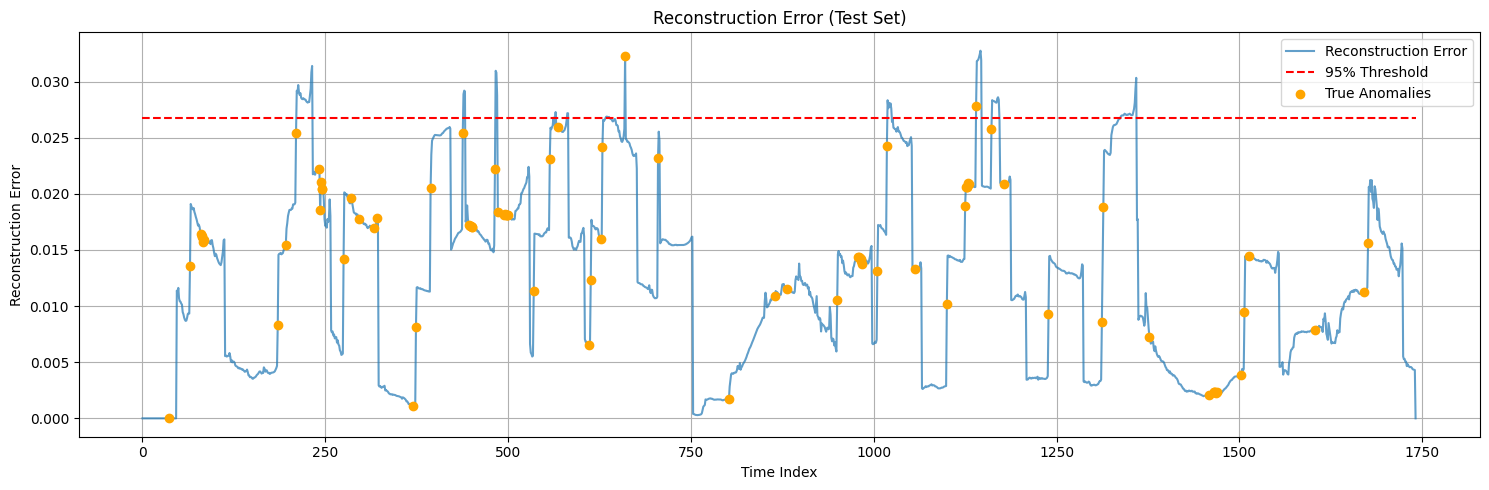

In [29]:
# Plot Reconstruction Error over Time
plt.figure(figsize=(15,5))
plt.plot(pointwise_errors, label='Reconstruction Error', alpha=0.7)
plt.hlines(np.percentile(valid_errors, 95), 0, len(pointwise_errors), colors='r', linestyles='dashed', label='95% Threshold')
plt.scatter(np.where(anomaly_labels==1), pointwise_errors[anomaly_labels==1], color='orange', label='True Anomalies', zorder=5)
plt.title('Reconstruction Error (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
# 7. Evaluate anomaly detection (If you have anomaly labels, evaluate detection performance)
threshold = np.percentile(valid_errors, 95)
predicted_labels = (valid_errors > threshold).astype(int)

# Compute Evaluation Metrics
roc_auc = roc_auc_score(valid_labels, valid_errors)
precision, recall, f1 = precision_score(valid_labels, predicted_labels), recall_score(valid_labels, predicted_labels), f1_score(valid_labels, predicted_labels)
ap_score = average_precision_score(valid_labels, valid_errors)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

ROC AUC: 0.6201
Precision: 0.0235, Recall: 0.0238, F1: 0.0237, AP: 0.0689


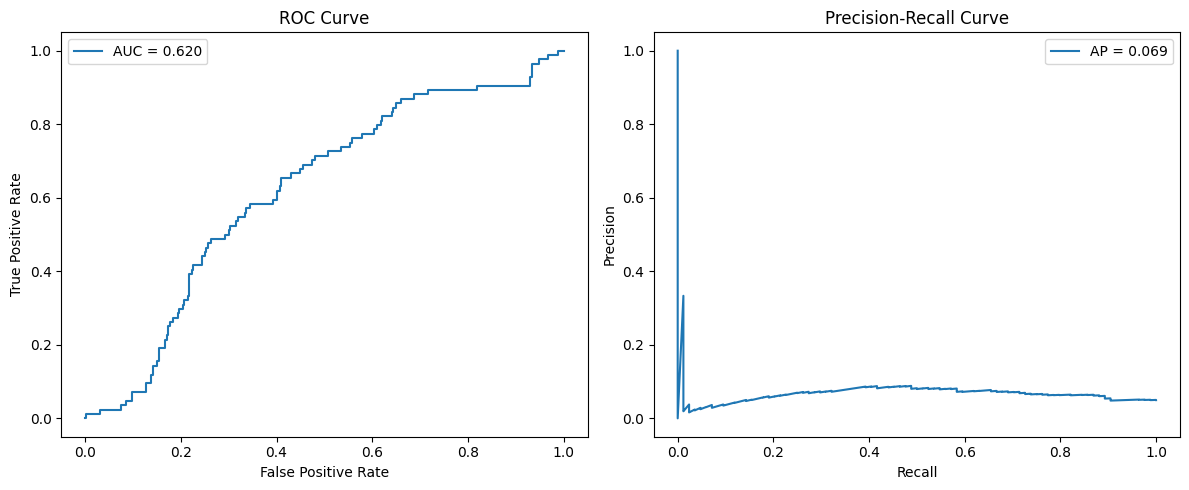

In [31]:
# 8. Plot ROC and Precision-Recall Curves
fpr, tpr, _ = roc_curve(valid_labels, valid_errors)
prec_curve, rec_curve, _ = precision_recall_curve(valid_labels, valid_errors)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_curve, prec_curve, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve"); plt.legend()

plt.tight_layout()
plt.show()


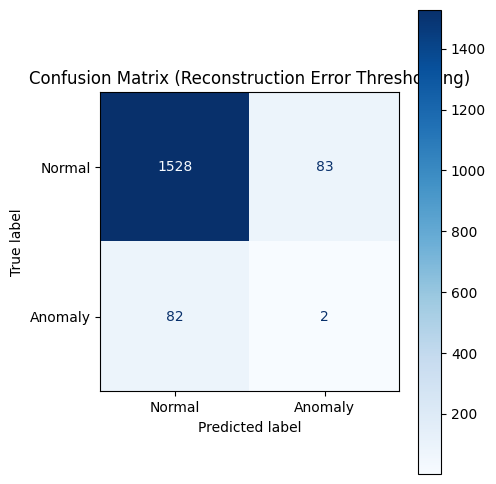

In [32]:
# 9. Plot confusion matrix
cm = confusion_matrix(valid_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Reconstruction Error Thresholding)")
plt.tight_layout()
plt.show()